**Importing Dataset and Taking out Sample**

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cols =  ['target','id','date','query','user','text']
data = pd.read_csv("Twitterdata.csv",names = cols,header = None,encoding = 'latin-1',engine='python', on_bad_lines='skip')

In [ ]:
samples = 100000
classes = data['target'].unique()
sampleperclass = int(100000/len(classes))

shortdata = data.groupby('target').apply(lambda x : x.sample(n=sampleperclass,random_state = 42)).reset_index(drop = True)


/tmp/ipython-input-2569364525.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shortdata = data.groupby('target').apply(lambda x : x.sample(n=sampleperclass,random_state = 42)).reset_index(drop = True)


**Dataset Balance/UnBalance Check**

In [ ]:
shortdata['target'].value_counts()

,count
target,
0,50000
4,50000


In [ ]:
shortdata.isnull().sum()   #no null values

,0
target,0
id,0
date,0
query,0
user,0
text,0


**Checking for Duplicate Rows**

In [ ]:
shortdata[data.duplicated()]    #no duplicated rows

/tmp/ipython-input-1957525863.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shortdata[data.duplicated()]    #no duplicated rows


,target,id,date,query,user,text


**Preprocessing**

**LowerCasing**

In [ ]:
shortdata['text'] = shortdata['text'].str.lower()

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 26.9 MB/s eta 0:00:00


**Conversion of emojis to text to handle emotions**

In [ ]:
import emoji
import re # Already in use but good to be explicit

def handle_emojis_and_clean(text):
    # 1. Convert Emojis to text description (e.g., '😂' -> ':face_with_tears_of_joy:')
    # The 'demojize' function converts the emoji to a text string, often enclosed in colons.
    text = emoji.demojize(text, delimiters=(" ", " "))

    # 2. Convert standard emoticons (simple regex-based replacement)
    # You can expand this list!
    text = text.replace(":)", " happyface ")
    text = text.replace(":(", " sadface ")
    text = text.replace(":D", " laughface ")
    text = text.replace(":-)", " happyface ")
    text = text.replace(":-(", " sadface ")

    # 3. Remove/replace punctuation and numbers, but keep the new text tokens
    # Replace anything NOT a letter, space, or colon (since emoji text uses colons) with a space.
    text = re.sub(r'[^a-zA-Z\s:]', ' ', text)

    # 4. Remove colons and convert to lowercase
    # Example: ':face_with_tears_of_joy:' -> 'face_with_tears_of_joy'
    text = text.replace(':', '')
    text = text.lower()

    return text

# Apply the new function
shortdata['text'] = shortdata['text'].apply(handle_emojis_and_clean)



**Tokenization**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
shortdata['text'] = shortdata['text'].apply(lambda x : word_tokenize(x))

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

**Lemmatizer for better Grammer handling**

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

def getWordnetpos(tag):
  if tag.startswith('J'):
      return wordnet.ADJ
  elif tag.startswith('V'):
      return wordnet.VERB
  elif tag.startswith('N'):
      return wordnet.NOUN
  elif tag.startswith('R'):
      return wordnet.ADV
  else:
      return wordnet.NOUN


lemmatizer = WordNetLemmatizer()
shortdata['text'] = shortdata['text'].apply(lambda x : [lemmatizer.lemmatize(token,getWordnetpos(pos)) for token,pos in nltk.pos_tag(x)])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


**Joining back token into strings**

In [ ]:
shortdata['text'] = shortdata['text'].apply(lambda x : " ".join(x))
shortdata['text'].head()

,text
0,xnausikaax oh no where do u order from that s ...
1,a great hard training weekend be over a couple...
2,right off to work only hour to go until i m fr...
3,i be crave for japanese food
4,jean michel jarre concert tomorrow get ta work...


**Train/Test Split**

In [ ]:
x = shortdata['text']
y = shortdata['target']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.80 , random_state=42)

**Text to Numerical Data Conversion (TFIDF-VECTORIZER)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,4), max_features=30000)
tfidf_train = tfidf.fit_transform(x_train)
tfidf_test = tfidf.transform(x_test)

**Model Training**

**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(tfidf_train,y_train)


MultinomialNB()

In [ ]:
nb.score(tfidf_train,y_train)*100, nb.score(tfidf_test,y_test)*100

(82.5725, 77.935)

**Evaluation**

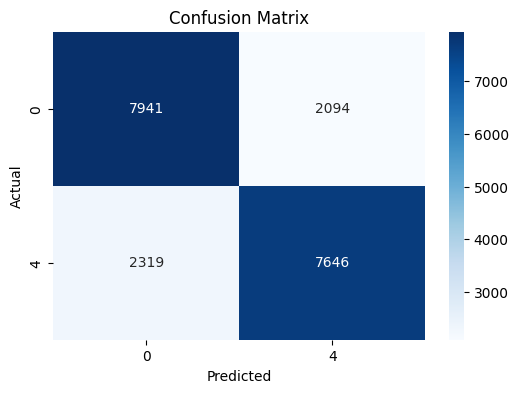

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     10035
           4       0.79      0.77      0.78      9965

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



In [27]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = nb.predict(tfidf_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0','4'],
            yticklabels=['0','4'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['0','4']))

**Logistic Regression with Hyperparameter Training**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.1, 1, 2, 5]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='accuracy')
grid.fit(tfidf_train, y_train)
print(grid.best_params_, grid.best_score_)


{'C': 1} 0.7844624899325187


**Evaluation**

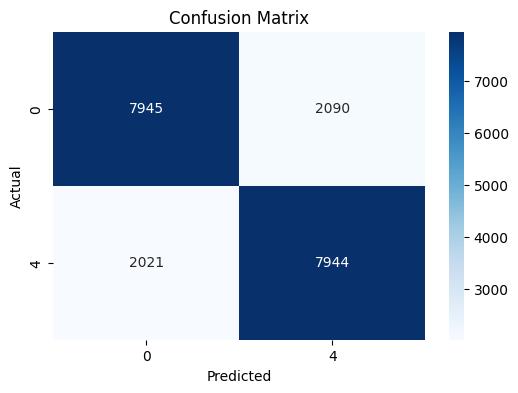

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     10035
           4       0.79      0.80      0.79      9965

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



In [29]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = grid.predict(tfidf_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0','4'],
            yticklabels=['0','4'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['0','4']))

**SVM**

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(tfidf_train,y_train)
svc.score(tfidf_train,y_train)*100 , svc.score(tfidf_test,y_test)*100

(90.00375000000001, 78.28)

**Evaluation**

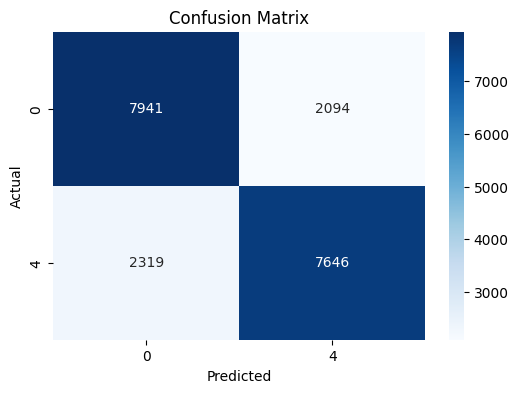

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     10035
           4       0.79      0.77      0.78      9965

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



In [30]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = nb.predict(tfidf_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0','4'],
            yticklabels=['0','4'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['0','4']))